In [656]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import SGD
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
#"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv"
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from numpy import concatenate

<h1>Make Multivariable Dataset</h1>
<h2>Load Chinook Data</h2>

In [445]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data # Create a copy for us to work with 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, 
          inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
#     print(salmon_copy)
    king_data = salmon_copy.filter(["date","king"], axis=1)
#     print(king_data)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [446]:
    chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
    ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
    abdul_path = '/Users/abdul/Downloads/SalmonNet/data.csv'
    king_all_copy, king_data= load_data(ismael_path)
    print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [447]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [448]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [449]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [450]:
data_copy

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [451]:
master_data = data_copy
master_data

,date,king
0,1939-01-31,6
1,1939-02-28,12
2,1939-03-31,121
3,1939-04-30,51410
4,1939-05-31,25159
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [452]:
master_data = master_data[132:]

In [453]:
master_data

,date,king
132,1950-01-31,0
133,1950-02-28,0
134,1950-03-31,21
135,1950-04-30,6630
136,1950-05-31,50638
...,...,...
979,2020-08-31,105269
980,2020-09-30,254930
981,2020-10-31,30917
982,2020-11-30,843


In [454]:
master_data.reset_index(inplace=True)

In [455]:
master_data = master_data.drop(labels='index', axis=1)

In [456]:
print(master_data)

          date    king
0   1950-01-31       0
1   1950-02-28       0
2   1950-03-31      21
3   1950-04-30    6630
4   1950-05-31   50638
..         ...     ...
847 2020-08-31  105269
848 2020-09-30  254930
849 2020-10-31   30917
850 2020-11-30     843
851 2020-12-31       9

[852 rows x 2 columns]


In [457]:
# type(data_copy['date'])
# # data_copy['date'].astype(p)

<h2>Load Covariate Data and Concat to Master_Data</h2>

In [458]:
def load_cov_set(pathname):
    data = pd.read_csv(pathname)
    return data

In [459]:
ismael_path_cov = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/covariates.csv'
cov_data = load_cov_set(ismael_path_cov)
cov_data

,year,month,upwelling,noi,npgo,pdo,oni
0,1950,1,-16,2.644,-2.190,-1.61,-1.40
1,1950,2,-166,2.077,-1.450,-2.17,-1.20
2,1950,3,-49,3.091,-0.970,-1.89,-1.10
3,1950,4,-4,1.923,-0.860,-1.99,-1.20
4,1950,5,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020,8,43,-0.463,-1.422,-1.32,-0.57
848,2020,9,-1,-0.276,-1.161,-1.03,-0.89
849,2020,10,10,1.612,-1.476,-0.62,-1.17
850,2020,11,-43,1.998,-1.710,-1.58,-1.27


In [460]:
upwelling = cov_data["upwelling"]
master_data = master_data.join(upwelling)
master_data

,date,king,upwelling
0,1950-01-31,0,-16
1,1950-02-28,0,-166
2,1950-03-31,21,-49
3,1950-04-30,6630,-4
4,1950-05-31,50638,49
...,...,...,...
847,2020-08-31,105269,43
848,2020-09-30,254930,-1
849,2020-10-31,30917,10
850,2020-11-30,843,-43


In [461]:
noi = cov_data["noi"]
master_data = master_data.join(noi)
master_data

,date,king,upwelling,noi
0,1950-01-31,0,-16,2.644
1,1950-02-28,0,-166,2.077
2,1950-03-31,21,-49,3.091
3,1950-04-30,6630,-4,1.923
4,1950-05-31,50638,49,2.211
...,...,...,...,...
847,2020-08-31,105269,43,-0.463
848,2020-09-30,254930,-1,-0.276
849,2020-10-31,30917,10,1.612
850,2020-11-30,843,-43,1.998


In [462]:
npgo = cov_data["npgo"]
master_data = master_data.join(npgo)
master_data

,date,king,upwelling,noi,npgo
0,1950-01-31,0,-16,2.644,-2.190
1,1950-02-28,0,-166,2.077,-1.450
2,1950-03-31,21,-49,3.091,-0.970
3,1950-04-30,6630,-4,1.923,-0.860
4,1950-05-31,50638,49,2.211,-0.630
...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422
848,2020-09-30,254930,-1,-0.276,-1.161
849,2020-10-31,30917,10,1.612,-1.476
850,2020-11-30,843,-43,1.998,-1.710


In [463]:
pdo = cov_data["pdo"]
master_data = master_data.join(pdo)
master_data

,date,king,upwelling,noi,npgo,pdo
0,1950-01-31,0,-16,2.644,-2.190,-1.61
1,1950-02-28,0,-166,2.077,-1.450,-2.17
2,1950-03-31,21,-49,3.091,-0.970,-1.89
3,1950-04-30,6630,-4,1.923,-0.860,-1.99
4,1950-05-31,50638,49,2.211,-0.630,-3.19
...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03
849,2020-10-31,30917,10,1.612,-1.476,-0.62
850,2020-11-30,843,-43,1.998,-1.710,-1.58


In [474]:
oni = cov_data["oni "]
master_data = master_data.join(oni)
master_data
# cov_data.columns

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [478]:
master_data = master_data.rename(columns={"oni ": "oni"})
master_data

,date,king,upwelling,noi,npgo,pdo,oni
0,1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1,1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
2,1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
3,1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
4,1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...,...
847,2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
848,2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
849,2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17
850,2020-11-30,843,-43,1.998,-1.710,-1.58,-1.27


In [480]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_cov_set(ismael_path_pdo)
# pdo_data

In [481]:
# master_data = data_copy

In [482]:
# pdo = pdo_data["PDO"]
# pdo = pdo[:984]
# pdo
# master_data = master_data.join(pdo)
# # master_data
# # master_data = master_data[:984]
# # master_data = master_data.reindex(columns=["Date", "Month", "king", "PDO"])
# # master_data

In [483]:
# # master_data.columns = ['year', 'month', 'king', 'pdo']
# master_data

In [484]:
# master_data

In [485]:
# master_data['year']=pd.to_datetime(master_data[['year','month']])
# master_data.set_index('date', inplace=True)
# master_data.index = pd.to_datetime(master_data.index)
# master_data

<h2> Load and Concat NOI data </h2>

In [486]:
# ismael_path_noi = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/noi.csv'
# noi_data = load_cov_set(ismael_path_noi)
# noi_data = noi_data[:877]
# noi_data = noi_data.drop(labels=0, axis=0)
# noi_data.reset_index()
# print(noi_data)
# print(noi_data['noix'])
# # noi_data = noi_data.drop(columns="index")

In [487]:
# noi = noi_data["noix"]
# # noi
# print(master_data)
# master_data = master_data[120:]
# print(master_data)
# master_data.reset_index()
# master_data = master_data.join(noi)

In [488]:
# master_data = master_data.reset_index()

In [489]:
# master_data
# master_data = master_data.drop(labels="index", axis=1)

In [490]:
# master_data.head(700)

In [491]:
master_data.set_index('date', inplace=True)
master_data.index = pd.to_datetime(master_data.index)
master_data

,king,upwelling,noi,npgo,pdo,oni
date,,,,,,
1950-01-31,0,-16,2.644,-2.190,-1.61,-1.40
1950-02-28,0,-166,2.077,-1.450,-2.17,-1.20
1950-03-31,21,-49,3.091,-0.970,-1.89,-1.10
1950-04-30,6630,-4,1.923,-0.860,-1.99,-1.20
1950-05-31,50638,49,2.211,-0.630,-3.19,-1.10
...,...,...,...,...,...,...
2020-08-31,105269,43,-0.463,-1.422,-1.32,-0.57
2020-09-30,254930,-1,-0.276,-1.161,-1.03,-0.89
2020-10-31,30917,10,1.612,-1.476,-0.62,-1.17


In [492]:
master_data.to_csv('master_data.csv')

In [648]:
checkpoint_filepath = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

<h2>Let's plot each series</h2>

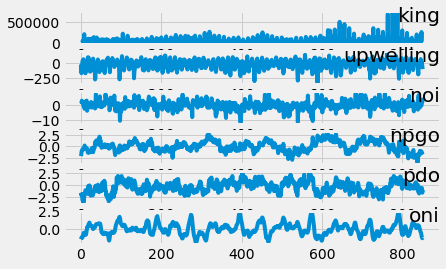

In [670]:
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=.5, loc='right')
    i += 1
plt.show()

<h2>Make Series into Train and Test Set with inputs and ouptuts</h2>

In [693]:
# convert series to supervised learning
def series_to_supervised(data, n_in=6, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('master_data.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_months = 6
n_features = 6
reframed = series_to_supervised(scaled, n_months, 1)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[13]], axis=1, inplace=True)
print(reframed.head())

    var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000006   0.520913   0.710488   0.220877   0.329032   0.119048   
7    0.000006   0.079848   0.683284   0.332829   0.238710   0.166667   
8    0.000035   0.399240   0.731936   0.405446   0.283871   0.190476   
9    0.009241   0.566540   0.675895   0.422088   0.267742   0.166667   
10   0.070540   0.764259   0.689713   0.456883   0.074194   0.190476   

    var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  ...  var3(t-1)  var4(t-1)  \
6    0.000006   0.079848   0.683284   0.332829  ...   0.632281   0.464448   
7    0.000035   0.399240   0.731936   0.405446  ...   0.567508   0.440242   
8    0.009241   0.566540   0.675895   0.422088  ...   0.572306   0.468986   
9    0.070540   0.764259   0.689713   0.456883  ...   0.591786   0.461422   
10   0.023221   0.703422   0.632281   0.464448  ...   0.461760   0.570348   

    var5(t-1)  var6(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)  \
6    0.182258   0.238095  

In [694]:
# split into train and test sets
values = reframed.values
n_train_months = 66 * 12 # MENTAL NOTE: IF ERROR IN MOTH TO YEAR CHECK THIS
train = values[:n_train_months, :]
test = values[n_train_months:, :]
# split into input and outputs
n_obs = n_months * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
# print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_months, n_features))
test_X = test_X.reshape((test_X.shape[0], n_months, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(792, 6, 6) (792,) (54, 6, 6) (54,)


In [695]:
X_train, X_dev, y_train, y_dev = train_test_split(train_X, train_y, test_size=0.10, shuffle=False)

In [696]:
print(X_dev.shape)
print(y_dev.shape)
print(X_train.shape)
print(y_train.shape)
print(test_X.shape)
print(test_y.shape)

(80, 6, 6)
(80,)
(712, 6, 6)
(712,)
(54, 6, 6)
(54,)


Epoch 1/2000
8/8 - 3s - loss: 0.0256 - mean_squared_error: 0.0256 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 2/2000
8/8 - 0s - loss: 0.0191 - mean_squared_error: 0.0191 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 3/2000
8/8 - 0s - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0495 - val_mean_squared_error: 0.0495
Epoch 4/2000
8/8 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0401 - val_mean_squared_error: 0.0401
Epoch 5/2000
8/8 - 0s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 6/2000
8/8 - 0s - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 7/2000
8/8 - 0s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0404 - val_mean_squared_error: 0.0404
Epoch 8/2000
8/8 - 0s - loss: 0.0090 - mean_squared_error: 0.0090 - val_loss: 0.0395 - val_mean_squared_error: 0.0395
Epoch 9/2000
8/8 - 0s - loss: 0.0090 - mean_squared_erro

Epoch 42/2000
8/8 - 0s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 43/2000
8/8 - 0s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 44/2000
8/8 - 0s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 45/2000
8/8 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0356 - val_mean_squared_error: 0.0356
Epoch 46/2000
8/8 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 47/2000
8/8 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 48/2000
8/8 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 49/2000
8/8 - 0s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 50/2000
8/8 - 0s - loss: 0.0077 - mean_squ

Epoch 83/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0345 - val_mean_squared_error: 0.0345
Epoch 84/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 85/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 86/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 87/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0344 - val_mean_squared_error: 0.0344
Epoch 88/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 89/2000
8/8 - 0s - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 90/2000
8/8 - 0s - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0343 - val_mean_squared_error: 0.0343
Epoch 91/2000
8/8 - 0s - loss: 0.0074 - mean_squ

8/8 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 124/2000
8/8 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0331 - val_mean_squared_error: 0.0331
Epoch 125/2000
8/8 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 126/2000
8/8 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 127/2000
8/8 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 128/2000
8/8 - 0s - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 129/2000
8/8 - 0s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 130/2000
8/8 - 0s - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0329 - val_mean_squared_error: 0.0329
Epoch 131/2000
8/8 - 0s - loss: 0.0071 - mean_squared_e

Epoch 164/2000
8/8 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 165/2000
8/8 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 166/2000
8/8 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 167/2000
8/8 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0317 - val_mean_squared_error: 0.0317
Epoch 168/2000
8/8 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 169/2000
8/8 - 0s - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0316 - val_mean_squared_error: 0.0316
Epoch 170/2000
8/8 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 171/2000
8/8 - 0s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 172/2000
8/8 - 0s - loss: 0.0068 -

Epoch 204/2000
8/8 - 0s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 205/2000
8/8 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0292 - val_mean_squared_error: 0.0292
Epoch 206/2000
8/8 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 207/2000
8/8 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 208/2000
8/8 - 0s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0287 - val_mean_squared_error: 0.0287
Epoch 209/2000
8/8 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 210/2000
8/8 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 211/2000
8/8 - 0s - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0283 - val_mean_squared_error: 0.0283
Epoch 212/2000
8/8 - 0s - loss: 0.0062 -

Epoch 245/2000
8/8 - 0s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0186 - val_mean_squared_error: 0.0186
Epoch 246/2000
8/8 - 0s - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0182 - val_mean_squared_error: 0.0182
Epoch 247/2000
8/8 - 0s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 248/2000
8/8 - 0s - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 249/2000
8/8 - 0s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 250/2000
8/8 - 0s - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 251/2000
8/8 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 252/2000
8/8 - 0s - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 253/2000
8/8 - 0s - loss: 0.0040 -

Epoch 285/2000
8/8 - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 286/2000
8/8 - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 287/2000
8/8 - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 288/2000
8/8 - 0s - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 289/2000
8/8 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 290/2000
8/8 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 291/2000
8/8 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 292/2000
8/8 - 0s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 293/2000
8/8 - 0s - loss: 0.0032 -

Epoch 326/2000
8/8 - 0s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 327/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 328/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 329/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 330/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 331/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 332/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 333/2000
8/8 - 0s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 334/2000
8/8 - 0s - loss: 0.0028 -

Epoch 366/2000
8/8 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 367/2000
8/8 - 0s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 368/2000
8/8 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 369/2000
8/8 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 370/2000
8/8 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 371/2000
8/8 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 372/2000
8/8 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 373/2000
8/8 - 0s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 374/2000
8/8 - 0s - loss: 0.0025 -

Epoch 407/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 408/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 409/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 410/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 411/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 412/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 413/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 414/2000
8/8 - 0s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 415/2000
8/8 - 0s - loss: 0.0023 -

Epoch 447/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 448/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 449/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 450/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 451/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 452/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 453/2000
8/8 - 0s - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 454/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 455/2000
8/8 - 0s - loss: 0.0020 -

Epoch 488/2000
8/8 - 0s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 489/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 490/2000
8/8 - 0s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 491/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 492/2000
8/8 - 0s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 493/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 494/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 495/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 496/2000
8/8 - 0s - loss: 0.0019 -

Epoch 528/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 529/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 530/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 531/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 532/2000
8/8 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 533/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 534/2000
8/8 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 535/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 536/2000
8/8 - 0s - loss: 0.0018 -

Epoch 569/2000
8/8 - 0s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 570/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 571/2000
8/8 - 0s - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 572/2000
8/8 - 0s - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 573/2000
8/8 - 0s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 574/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 575/2000
8/8 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 576/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 577/2000
8/8 - 0s - loss: 0.0016 -

Epoch 609/2000
8/8 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 610/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 611/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 612/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 613/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 614/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 615/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 616/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 617/2000
8/8 - 0s - loss: 0.0015 -

Epoch 650/2000
8/8 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 651/2000
8/8 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 652/2000
8/8 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 653/2000
8/8 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 654/2000
8/8 - 0s - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 655/2000
8/8 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 656/2000
8/8 - 0s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 657/2000
8/8 - 0s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 658/2000
8/8 - 0s - loss: 0.0017 -

Epoch 690/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 691/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 692/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 693/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 694/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 695/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 696/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 697/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 698/2000
8/8 - 0s - loss: 0.0011 -

Epoch 731/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 732/2000
8/8 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 733/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 734/2000
8/8 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 735/2000
8/8 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 736/2000
8/8 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 737/2000
8/8 - 0s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 738/2000
8/8 - 0s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 739/2000
8/8 - 0s - loss: 0.0012 -

Epoch 771/2000
8/8 - 0s - loss: 8.9460e-04 - mean_squared_error: 8.9460e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 772/2000
8/8 - 0s - loss: 9.4297e-04 - mean_squared_error: 9.4297e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 773/2000
8/8 - 0s - loss: 8.9295e-04 - mean_squared_error: 8.9295e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 774/2000
8/8 - 0s - loss: 9.3301e-04 - mean_squared_error: 9.3301e-04 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 775/2000
8/8 - 0s - loss: 8.8401e-04 - mean_squared_error: 8.8401e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 776/2000
8/8 - 0s - loss: 9.2727e-04 - mean_squared_error: 9.2727e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 777/2000
8/8 - 0s - loss: 8.8067e-04 - mean_squared_error: 8.8067e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 778/2000
8/8 - 0s - loss: 9.2138e-04 - mean_squared_error: 9.2138e-04 - val_loss: 0.0017 - val_mea

Epoch 811/2000
8/8 - 0s - loss: 8.6241e-04 - mean_squared_error: 8.6241e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 812/2000
8/8 - 0s - loss: 9.7771e-04 - mean_squared_error: 9.7771e-04 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 813/2000
8/8 - 0s - loss: 8.3922e-04 - mean_squared_error: 8.3922e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 814/2000
8/8 - 0s - loss: 9.3174e-04 - mean_squared_error: 9.3174e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 815/2000
8/8 - 0s - loss: 8.2094e-04 - mean_squared_error: 8.2094e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 816/2000
8/8 - 0s - loss: 8.9969e-04 - mean_squared_error: 8.9969e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 817/2000
8/8 - 0s - loss: 8.0655e-04 - mean_squared_error: 8.0655e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 818/2000
8/8 - 0s - loss: 8.7871e-04 - mean_squared_error: 8.7871e-04 - val_loss: 0.0015 - val_mea

Epoch 850/2000
8/8 - 0s - loss: 9.5320e-04 - mean_squared_error: 9.5320e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 851/2000
8/8 - 0s - loss: 8.1331e-04 - mean_squared_error: 8.1331e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 852/2000
8/8 - 0s - loss: 9.4047e-04 - mean_squared_error: 9.4047e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 853/2000
8/8 - 0s - loss: 7.9894e-04 - mean_squared_error: 7.9894e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 854/2000
8/8 - 0s - loss: 9.1820e-04 - mean_squared_error: 9.1820e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 855/2000
8/8 - 0s - loss: 7.8477e-04 - mean_squared_error: 7.8477e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 856/2000
8/8 - 0s - loss: 8.8868e-04 - mean_squared_error: 8.8868e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 857/2000
8/8 - 0s - loss: 7.6590e-04 - mean_squared_error: 7.6590e-04 - val_loss: 0.0012 - val_mea

Epoch 889/2000
8/8 - 0s - loss: 7.2813e-04 - mean_squared_error: 7.2813e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 890/2000
8/8 - 0s - loss: 8.1977e-04 - mean_squared_error: 8.1977e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 891/2000
8/8 - 0s - loss: 7.1994e-04 - mean_squared_error: 7.1994e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 892/2000
8/8 - 0s - loss: 8.2002e-04 - mean_squared_error: 8.2002e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 893/2000
8/8 - 0s - loss: 7.1088e-04 - mean_squared_error: 7.1088e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 894/2000
8/8 - 0s - loss: 8.2334e-04 - mean_squared_error: 8.2334e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 895/2000
8/8 - 0s - loss: 7.1356e-04 - mean_squared_error: 7.1356e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 896/2000
8/8 - 0s - loss: 8.1546e-04 - mean_squared_error: 8.1546e-04 - val_loss: 0.0012 - val_mea

Epoch 928/2000
8/8 - 0s - loss: 7.1925e-04 - mean_squared_error: 7.1925e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 929/2000
8/8 - 0s - loss: 6.5348e-04 - mean_squared_error: 6.5348e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 930/2000
8/8 - 0s - loss: 7.7148e-04 - mean_squared_error: 7.7148e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 931/2000
8/8 - 0s - loss: 6.9132e-04 - mean_squared_error: 6.9132e-04 - val_loss: 8.9678e-04 - val_mean_squared_error: 8.9678e-04
Epoch 932/2000
8/8 - 0s - loss: 8.1211e-04 - mean_squared_error: 8.1211e-04 - val_loss: 9.5222e-04 - val_mean_squared_error: 9.5222e-04
Epoch 933/2000
8/8 - 0s - loss: 7.2513e-04 - mean_squared_error: 7.2513e-04 - val_loss: 8.7643e-04 - val_mean_squared_error: 8.7643e-04
Epoch 934/2000
8/8 - 0s - loss: 7.6155e-04 - mean_squared_error: 7.6155e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 935/2000
8/8 - 0s - loss: 7.7660e-04 - mean_squared_error: 7.7660e-04 - va

Epoch 966/2000
8/8 - 0s - loss: 6.6798e-04 - mean_squared_error: 6.6798e-04 - val_loss: 8.1769e-04 - val_mean_squared_error: 8.1769e-04
Epoch 967/2000
8/8 - 0s - loss: 6.8561e-04 - mean_squared_error: 6.8561e-04 - val_loss: 9.1046e-04 - val_mean_squared_error: 9.1046e-04
Epoch 968/2000
8/8 - 0s - loss: 6.1958e-04 - mean_squared_error: 6.1958e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 969/2000
8/8 - 0s - loss: 6.3120e-04 - mean_squared_error: 6.3120e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 970/2000
8/8 - 0s - loss: 6.1764e-04 - mean_squared_error: 6.1764e-04 - val_loss: 7.7755e-04 - val_mean_squared_error: 7.7755e-04
Epoch 971/2000
8/8 - 0s - loss: 5.6979e-04 - mean_squared_error: 5.6979e-04 - val_loss: 7.4512e-04 - val_mean_squared_error: 7.4512e-04
Epoch 972/2000
8/8 - 0s - loss: 6.0482e-04 - mean_squared_error: 6.0482e-04 - val_loss: 8.9023e-04 - val_mean_squared_error: 8.9023e-04
Epoch 973/2000
8/8 - 0s - loss: 5.8359e-04 - mean_squared_error:

Epoch 1004/2000
8/8 - 0s - loss: 5.3968e-04 - mean_squared_error: 5.3968e-04 - val_loss: 7.7620e-04 - val_mean_squared_error: 7.7620e-04
Epoch 1005/2000
8/8 - 0s - loss: 5.2131e-04 - mean_squared_error: 5.2131e-04 - val_loss: 7.5953e-04 - val_mean_squared_error: 7.5953e-04
Epoch 1006/2000
8/8 - 0s - loss: 5.4824e-04 - mean_squared_error: 5.4824e-04 - val_loss: 8.0926e-04 - val_mean_squared_error: 8.0926e-04
Epoch 1007/2000
8/8 - 0s - loss: 4.9389e-04 - mean_squared_error: 4.9389e-04 - val_loss: 7.0124e-04 - val_mean_squared_error: 7.0124e-04
Epoch 1008/2000
8/8 - 0s - loss: 5.3737e-04 - mean_squared_error: 5.3737e-04 - val_loss: 7.5872e-04 - val_mean_squared_error: 7.5872e-04
Epoch 1009/2000
8/8 - 0s - loss: 5.2136e-04 - mean_squared_error: 5.2136e-04 - val_loss: 7.4362e-04 - val_mean_squared_error: 7.4362e-04
Epoch 1010/2000
8/8 - 0s - loss: 5.4686e-04 - mean_squared_error: 5.4686e-04 - val_loss: 7.9209e-04 - val_mean_squared_error: 7.9209e-04
Epoch 1011/2000
8/8 - 0s - loss: 5.0494e-

Epoch 1041/2000
8/8 - 0s - loss: 5.0593e-04 - mean_squared_error: 5.0593e-04 - val_loss: 7.1362e-04 - val_mean_squared_error: 7.1362e-04
Epoch 1042/2000
8/8 - 0s - loss: 5.3974e-04 - mean_squared_error: 5.3974e-04 - val_loss: 6.9794e-04 - val_mean_squared_error: 6.9794e-04
Epoch 1043/2000
8/8 - 0s - loss: 4.5659e-04 - mean_squared_error: 4.5659e-04 - val_loss: 6.2680e-04 - val_mean_squared_error: 6.2680e-04
Epoch 1044/2000
8/8 - 0s - loss: 5.2402e-04 - mean_squared_error: 5.2402e-04 - val_loss: 7.2104e-04 - val_mean_squared_error: 7.2104e-04
Epoch 1045/2000
8/8 - 0s - loss: 4.8935e-04 - mean_squared_error: 4.8935e-04 - val_loss: 6.7966e-04 - val_mean_squared_error: 6.7966e-04
Epoch 1046/2000
8/8 - 0s - loss: 5.1825e-04 - mean_squared_error: 5.1825e-04 - val_loss: 6.8519e-04 - val_mean_squared_error: 6.8519e-04
Epoch 1047/2000
8/8 - 0s - loss: 4.5953e-04 - mean_squared_error: 4.5953e-04 - val_loss: 6.4091e-04 - val_mean_squared_error: 6.4091e-04
Epoch 1048/2000
8/8 - 0s - loss: 5.1947e-

Epoch 1079/2000
8/8 - 0s - loss: 4.2990e-04 - mean_squared_error: 4.2990e-04 - val_loss: 5.8468e-04 - val_mean_squared_error: 5.8468e-04
Epoch 1080/2000
8/8 - 0s - loss: 4.9498e-04 - mean_squared_error: 4.9498e-04 - val_loss: 6.5757e-04 - val_mean_squared_error: 6.5757e-04
Epoch 1081/2000
8/8 - 0s - loss: 4.4220e-04 - mean_squared_error: 4.4220e-04 - val_loss: 5.9987e-04 - val_mean_squared_error: 5.9987e-04
Epoch 1082/2000
8/8 - 0s - loss: 4.7233e-04 - mean_squared_error: 4.7233e-04 - val_loss: 5.7063e-04 - val_mean_squared_error: 5.7063e-04
Epoch 1083/2000
8/8 - 0s - loss: 4.1495e-04 - mean_squared_error: 4.1495e-04 - val_loss: 5.5409e-04 - val_mean_squared_error: 5.5409e-04
Epoch 1084/2000
8/8 - 0s - loss: 4.8601e-04 - mean_squared_error: 4.8601e-04 - val_loss: 6.5671e-04 - val_mean_squared_error: 6.5671e-04
Epoch 1085/2000
8/8 - 0s - loss: 4.5705e-04 - mean_squared_error: 4.5705e-04 - val_loss: 6.4880e-04 - val_mean_squared_error: 6.4880e-04
Epoch 1086/2000
8/8 - 0s - loss: 4.8509e-

Epoch 1116/2000
8/8 - 0s - loss: 4.8374e-04 - mean_squared_error: 4.8374e-04 - val_loss: 8.3758e-04 - val_mean_squared_error: 8.3758e-04
Epoch 1117/2000
8/8 - 0s - loss: 4.8058e-04 - mean_squared_error: 4.8058e-04 - val_loss: 5.0389e-04 - val_mean_squared_error: 5.0389e-04
Epoch 1118/2000
8/8 - 0s - loss: 3.7973e-04 - mean_squared_error: 3.7973e-04 - val_loss: 4.7704e-04 - val_mean_squared_error: 4.7704e-04
Epoch 1119/2000
8/8 - 0s - loss: 3.7625e-04 - mean_squared_error: 3.7625e-04 - val_loss: 5.1463e-04 - val_mean_squared_error: 5.1463e-04
Epoch 1120/2000
8/8 - 0s - loss: 3.8605e-04 - mean_squared_error: 3.8605e-04 - val_loss: 5.6367e-04 - val_mean_squared_error: 5.6367e-04
Epoch 1121/2000
8/8 - 0s - loss: 3.5917e-04 - mean_squared_error: 3.5917e-04 - val_loss: 4.9524e-04 - val_mean_squared_error: 4.9524e-04
Epoch 1122/2000
8/8 - 0s - loss: 3.4319e-04 - mean_squared_error: 3.4319e-04 - val_loss: 4.6806e-04 - val_mean_squared_error: 4.6806e-04
Epoch 1123/2000
8/8 - 0s - loss: 3.3639e-

Epoch 1154/2000
8/8 - 0s - loss: 4.1135e-04 - mean_squared_error: 4.1135e-04 - val_loss: 5.1886e-04 - val_mean_squared_error: 5.1886e-04
Epoch 1155/2000
8/8 - 0s - loss: 3.9843e-04 - mean_squared_error: 3.9843e-04 - val_loss: 5.4012e-04 - val_mean_squared_error: 5.4012e-04
Epoch 1156/2000
8/8 - 0s - loss: 3.9579e-04 - mean_squared_error: 3.9579e-04 - val_loss: 5.2486e-04 - val_mean_squared_error: 5.2486e-04
Epoch 1157/2000
8/8 - 0s - loss: 3.6892e-04 - mean_squared_error: 3.6892e-04 - val_loss: 4.8249e-04 - val_mean_squared_error: 4.8249e-04
Epoch 1158/2000
8/8 - 0s - loss: 4.0862e-04 - mean_squared_error: 4.0862e-04 - val_loss: 5.1909e-04 - val_mean_squared_error: 5.1909e-04
Epoch 1159/2000
8/8 - 0s - loss: 4.0323e-04 - mean_squared_error: 4.0323e-04 - val_loss: 5.4704e-04 - val_mean_squared_error: 5.4704e-04
Epoch 1160/2000
8/8 - 0s - loss: 3.9390e-04 - mean_squared_error: 3.9390e-04 - val_loss: 5.0499e-04 - val_mean_squared_error: 5.0499e-04
Epoch 1161/2000
8/8 - 0s - loss: 3.4218e-

Epoch 1191/2000
8/8 - 0s - loss: 4.6545e-04 - mean_squared_error: 4.6545e-04 - val_loss: 5.6855e-04 - val_mean_squared_error: 5.6855e-04
Epoch 1192/2000
8/8 - 0s - loss: 5.3831e-04 - mean_squared_error: 5.3831e-04 - val_loss: 8.6996e-04 - val_mean_squared_error: 8.6996e-04
Epoch 1193/2000
8/8 - 0s - loss: 7.1365e-04 - mean_squared_error: 7.1365e-04 - val_loss: 4.1598e-04 - val_mean_squared_error: 4.1598e-04
Epoch 1194/2000
8/8 - 0s - loss: 6.0817e-04 - mean_squared_error: 6.0817e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 1195/2000
8/8 - 0s - loss: 6.4319e-04 - mean_squared_error: 6.4319e-04 - val_loss: 4.6113e-04 - val_mean_squared_error: 4.6113e-04
Epoch 1196/2000
8/8 - 0s - loss: 4.4183e-04 - mean_squared_error: 4.4183e-04 - val_loss: 5.2197e-04 - val_mean_squared_error: 5.2197e-04
Epoch 1197/2000
8/8 - 0s - loss: 3.9842e-04 - mean_squared_error: 3.9842e-04 - val_loss: 5.3760e-04 - val_mean_squared_error: 5.3760e-04
Epoch 1198/2000
8/8 - 0s - loss: 4.1567e-04 - mea

Epoch 1229/2000
8/8 - 0s - loss: 3.3700e-04 - mean_squared_error: 3.3700e-04 - val_loss: 4.2262e-04 - val_mean_squared_error: 4.2262e-04
Epoch 1230/2000
8/8 - 0s - loss: 3.7230e-04 - mean_squared_error: 3.7230e-04 - val_loss: 4.4111e-04 - val_mean_squared_error: 4.4111e-04
Epoch 1231/2000
8/8 - 0s - loss: 3.3208e-04 - mean_squared_error: 3.3208e-04 - val_loss: 3.7094e-04 - val_mean_squared_error: 3.7094e-04
Epoch 1232/2000
8/8 - 0s - loss: 3.7683e-04 - mean_squared_error: 3.7683e-04 - val_loss: 3.9358e-04 - val_mean_squared_error: 3.9358e-04
Epoch 1233/2000
8/8 - 0s - loss: 3.6715e-04 - mean_squared_error: 3.6715e-04 - val_loss: 3.9887e-04 - val_mean_squared_error: 3.9887e-04
Epoch 1234/2000
8/8 - 0s - loss: 4.2634e-04 - mean_squared_error: 4.2634e-04 - val_loss: 5.0748e-04 - val_mean_squared_error: 5.0748e-04
Epoch 1235/2000
8/8 - 0s - loss: 3.7742e-04 - mean_squared_error: 3.7742e-04 - val_loss: 4.3946e-04 - val_mean_squared_error: 4.3946e-04
Epoch 1236/2000
8/8 - 0s - loss: 4.2205e-

Epoch 1266/2000
8/8 - 0s - loss: 4.0871e-04 - mean_squared_error: 4.0871e-04 - val_loss: 5.2615e-04 - val_mean_squared_error: 5.2615e-04
Epoch 1267/2000
8/8 - 0s - loss: 3.7458e-04 - mean_squared_error: 3.7458e-04 - val_loss: 5.5659e-04 - val_mean_squared_error: 5.5659e-04
Epoch 1268/2000
8/8 - 0s - loss: 3.9715e-04 - mean_squared_error: 3.9715e-04 - val_loss: 3.2295e-04 - val_mean_squared_error: 3.2295e-04
Epoch 1269/2000
8/8 - 0s - loss: 3.5809e-04 - mean_squared_error: 3.5809e-04 - val_loss: 3.6924e-04 - val_mean_squared_error: 3.6924e-04
Epoch 1270/2000
8/8 - 0s - loss: 4.4428e-04 - mean_squared_error: 4.4428e-04 - val_loss: 5.4267e-04 - val_mean_squared_error: 5.4267e-04
Epoch 1271/2000
8/8 - 0s - loss: 4.4918e-04 - mean_squared_error: 4.4918e-04 - val_loss: 6.3468e-04 - val_mean_squared_error: 6.3468e-04
Epoch 1272/2000
8/8 - 0s - loss: 4.4900e-04 - mean_squared_error: 4.4900e-04 - val_loss: 4.8499e-04 - val_mean_squared_error: 4.8499e-04
Epoch 1273/2000
8/8 - 0s - loss: 3.2973e-

Epoch 1304/2000
8/8 - 0s - loss: 3.2765e-04 - mean_squared_error: 3.2765e-04 - val_loss: 5.0301e-04 - val_mean_squared_error: 5.0301e-04
Epoch 1305/2000
8/8 - 0s - loss: 3.4556e-04 - mean_squared_error: 3.4556e-04 - val_loss: 3.6411e-04 - val_mean_squared_error: 3.6411e-04
Epoch 1306/2000
8/8 - 0s - loss: 3.3752e-04 - mean_squared_error: 3.3752e-04 - val_loss: 3.9225e-04 - val_mean_squared_error: 3.9225e-04
Epoch 1307/2000
8/8 - 0s - loss: 2.9281e-04 - mean_squared_error: 2.9281e-04 - val_loss: 3.6611e-04 - val_mean_squared_error: 3.6611e-04
Epoch 1308/2000
8/8 - 0s - loss: 3.1204e-04 - mean_squared_error: 3.1204e-04 - val_loss: 3.5341e-04 - val_mean_squared_error: 3.5341e-04
Epoch 1309/2000
8/8 - 0s - loss: 3.0923e-04 - mean_squared_error: 3.0923e-04 - val_loss: 3.4663e-04 - val_mean_squared_error: 3.4663e-04
Epoch 1310/2000
8/8 - 0s - loss: 3.5314e-04 - mean_squared_error: 3.5314e-04 - val_loss: 5.2500e-04 - val_mean_squared_error: 5.2500e-04
Epoch 1311/2000
8/8 - 0s - loss: 3.2665e-

Epoch 1341/2000
8/8 - 0s - loss: 3.1802e-04 - mean_squared_error: 3.1802e-04 - val_loss: 2.8196e-04 - val_mean_squared_error: 2.8196e-04
Epoch 1342/2000
8/8 - 0s - loss: 2.9383e-04 - mean_squared_error: 2.9383e-04 - val_loss: 4.2822e-04 - val_mean_squared_error: 4.2822e-04
Epoch 1343/2000
8/8 - 0s - loss: 3.5569e-04 - mean_squared_error: 3.5569e-04 - val_loss: 4.0772e-04 - val_mean_squared_error: 4.0772e-04
Epoch 1344/2000
8/8 - 0s - loss: 3.2978e-04 - mean_squared_error: 3.2978e-04 - val_loss: 4.1017e-04 - val_mean_squared_error: 4.1017e-04
Epoch 1345/2000
8/8 - 0s - loss: 2.5442e-04 - mean_squared_error: 2.5442e-04 - val_loss: 2.8883e-04 - val_mean_squared_error: 2.8883e-04
Epoch 1346/2000
8/8 - 0s - loss: 2.4409e-04 - mean_squared_error: 2.4409e-04 - val_loss: 2.5818e-04 - val_mean_squared_error: 2.5818e-04
Epoch 1347/2000
8/8 - 0s - loss: 2.8534e-04 - mean_squared_error: 2.8534e-04 - val_loss: 3.1014e-04 - val_mean_squared_error: 3.1014e-04
Epoch 1348/2000
8/8 - 0s - loss: 2.6627e-

Epoch 1379/2000
8/8 - 0s - loss: 2.9244e-04 - mean_squared_error: 2.9244e-04 - val_loss: 2.7414e-04 - val_mean_squared_error: 2.7414e-04
Epoch 1380/2000
8/8 - 0s - loss: 2.2883e-04 - mean_squared_error: 2.2883e-04 - val_loss: 2.0070e-04 - val_mean_squared_error: 2.0070e-04
Epoch 1381/2000
8/8 - 0s - loss: 2.4951e-04 - mean_squared_error: 2.4951e-04 - val_loss: 2.5074e-04 - val_mean_squared_error: 2.5074e-04
Epoch 1382/2000
8/8 - 0s - loss: 3.1561e-04 - mean_squared_error: 3.1561e-04 - val_loss: 3.8254e-04 - val_mean_squared_error: 3.8254e-04
Epoch 1383/2000
8/8 - 0s - loss: 3.3409e-04 - mean_squared_error: 3.3409e-04 - val_loss: 3.3737e-04 - val_mean_squared_error: 3.3737e-04
Epoch 1384/2000
8/8 - 0s - loss: 2.6337e-04 - mean_squared_error: 2.6337e-04 - val_loss: 2.5790e-04 - val_mean_squared_error: 2.5790e-04
Epoch 1385/2000
8/8 - 0s - loss: 2.9317e-04 - mean_squared_error: 2.9317e-04 - val_loss: 2.1626e-04 - val_mean_squared_error: 2.1626e-04
Epoch 1386/2000
8/8 - 0s - loss: 3.3402e-

Epoch 1416/2000
8/8 - 0s - loss: 1.8211e-04 - mean_squared_error: 1.8211e-04 - val_loss: 2.4035e-04 - val_mean_squared_error: 2.4035e-04
Epoch 1417/2000
8/8 - 0s - loss: 1.7542e-04 - mean_squared_error: 1.7542e-04 - val_loss: 2.0273e-04 - val_mean_squared_error: 2.0273e-04
Epoch 1418/2000
8/8 - 0s - loss: 1.8270e-04 - mean_squared_error: 1.8270e-04 - val_loss: 2.2724e-04 - val_mean_squared_error: 2.2724e-04
Epoch 1419/2000
8/8 - 0s - loss: 1.6987e-04 - mean_squared_error: 1.6987e-04 - val_loss: 2.4077e-04 - val_mean_squared_error: 2.4077e-04
Epoch 1420/2000
8/8 - 0s - loss: 1.6374e-04 - mean_squared_error: 1.6374e-04 - val_loss: 2.1377e-04 - val_mean_squared_error: 2.1377e-04
Epoch 1421/2000
8/8 - 0s - loss: 1.6790e-04 - mean_squared_error: 1.6790e-04 - val_loss: 2.0021e-04 - val_mean_squared_error: 2.0021e-04
Epoch 1422/2000
8/8 - 0s - loss: 1.7856e-04 - mean_squared_error: 1.7856e-04 - val_loss: 2.5200e-04 - val_mean_squared_error: 2.5200e-04
Epoch 1423/2000
8/8 - 0s - loss: 1.7738e-

Epoch 1454/2000
8/8 - 0s - loss: 3.5575e-04 - mean_squared_error: 3.5575e-04 - val_loss: 5.8445e-04 - val_mean_squared_error: 5.8445e-04
Epoch 1455/2000
8/8 - 0s - loss: 5.1914e-04 - mean_squared_error: 5.1914e-04 - val_loss: 2.5217e-04 - val_mean_squared_error: 2.5217e-04
Epoch 1456/2000
8/8 - 0s - loss: 4.8784e-04 - mean_squared_error: 4.8784e-04 - val_loss: 6.5697e-04 - val_mean_squared_error: 6.5697e-04
Epoch 1457/2000
8/8 - 0s - loss: 6.4432e-04 - mean_squared_error: 6.4432e-04 - val_loss: 4.6970e-04 - val_mean_squared_error: 4.6970e-04
Epoch 1458/2000
8/8 - 0s - loss: 5.0021e-04 - mean_squared_error: 5.0021e-04 - val_loss: 5.3880e-04 - val_mean_squared_error: 5.3880e-04
Epoch 1459/2000
8/8 - 0s - loss: 3.8276e-04 - mean_squared_error: 3.8276e-04 - val_loss: 2.9383e-04 - val_mean_squared_error: 2.9383e-04
Epoch 1460/2000
8/8 - 0s - loss: 4.6293e-04 - mean_squared_error: 4.6293e-04 - val_loss: 3.4520e-04 - val_mean_squared_error: 3.4520e-04
Epoch 1461/2000
8/8 - 0s - loss: 5.5382e-

Epoch 1491/2000
8/8 - 0s - loss: 1.5805e-04 - mean_squared_error: 1.5805e-04 - val_loss: 2.0449e-04 - val_mean_squared_error: 2.0449e-04
Epoch 1492/2000
8/8 - 0s - loss: 1.4720e-04 - mean_squared_error: 1.4720e-04 - val_loss: 1.6747e-04 - val_mean_squared_error: 1.6747e-04
Epoch 1493/2000
8/8 - 0s - loss: 1.5157e-04 - mean_squared_error: 1.5157e-04 - val_loss: 1.7102e-04 - val_mean_squared_error: 1.7102e-04
Epoch 1494/2000
8/8 - 0s - loss: 1.5914e-04 - mean_squared_error: 1.5914e-04 - val_loss: 2.0998e-04 - val_mean_squared_error: 2.0998e-04
Epoch 1495/2000
8/8 - 0s - loss: 1.4937e-04 - mean_squared_error: 1.4937e-04 - val_loss: 1.9005e-04 - val_mean_squared_error: 1.9005e-04
Epoch 1496/2000
8/8 - 0s - loss: 1.4265e-04 - mean_squared_error: 1.4265e-04 - val_loss: 1.6079e-04 - val_mean_squared_error: 1.6079e-04
Epoch 1497/2000
8/8 - 0s - loss: 1.5105e-04 - mean_squared_error: 1.5105e-04 - val_loss: 1.7343e-04 - val_mean_squared_error: 1.7343e-04
Epoch 1498/2000
8/8 - 0s - loss: 1.5969e-

Epoch 1529/2000
8/8 - 0s - loss: 2.5388e-04 - mean_squared_error: 2.5388e-04 - val_loss: 1.9800e-04 - val_mean_squared_error: 1.9800e-04
Epoch 1530/2000
8/8 - 0s - loss: 3.0309e-04 - mean_squared_error: 3.0309e-04 - val_loss: 3.6908e-04 - val_mean_squared_error: 3.6908e-04
Epoch 1531/2000
8/8 - 0s - loss: 2.9901e-04 - mean_squared_error: 2.9901e-04 - val_loss: 3.3871e-04 - val_mean_squared_error: 3.3871e-04
Epoch 1532/2000
8/8 - 0s - loss: 3.0663e-04 - mean_squared_error: 3.0663e-04 - val_loss: 2.2846e-04 - val_mean_squared_error: 2.2846e-04
Epoch 1533/2000
8/8 - 0s - loss: 2.8069e-04 - mean_squared_error: 2.8069e-04 - val_loss: 2.1526e-04 - val_mean_squared_error: 2.1526e-04
Epoch 1534/2000
8/8 - 0s - loss: 2.9596e-04 - mean_squared_error: 2.9596e-04 - val_loss: 3.2691e-04 - val_mean_squared_error: 3.2691e-04
Epoch 1535/2000
8/8 - 0s - loss: 2.5499e-04 - mean_squared_error: 2.5499e-04 - val_loss: 2.5877e-04 - val_mean_squared_error: 2.5877e-04
Epoch 1536/2000
8/8 - 0s - loss: 2.3832e-

Epoch 1566/2000
8/8 - 0s - loss: 1.5861e-04 - mean_squared_error: 1.5861e-04 - val_loss: 1.7876e-04 - val_mean_squared_error: 1.7876e-04
Epoch 1567/2000
8/8 - 0s - loss: 1.3961e-04 - mean_squared_error: 1.3961e-04 - val_loss: 1.6148e-04 - val_mean_squared_error: 1.6148e-04
Epoch 1568/2000
8/8 - 0s - loss: 1.4315e-04 - mean_squared_error: 1.4315e-04 - val_loss: 1.5825e-04 - val_mean_squared_error: 1.5825e-04
Epoch 1569/2000
8/8 - 0s - loss: 1.5873e-04 - mean_squared_error: 1.5873e-04 - val_loss: 1.7296e-04 - val_mean_squared_error: 1.7296e-04
Epoch 1570/2000
8/8 - 0s - loss: 1.4150e-04 - mean_squared_error: 1.4150e-04 - val_loss: 1.6808e-04 - val_mean_squared_error: 1.6808e-04
Epoch 1571/2000
8/8 - 0s - loss: 1.4665e-04 - mean_squared_error: 1.4665e-04 - val_loss: 1.5957e-04 - val_mean_squared_error: 1.5957e-04
Epoch 1572/2000
8/8 - 0s - loss: 1.4064e-04 - mean_squared_error: 1.4064e-04 - val_loss: 1.6492e-04 - val_mean_squared_error: 1.6492e-04
Epoch 1573/2000
8/8 - 0s - loss: 1.5211e-

Epoch 1604/2000
8/8 - 0s - loss: 2.6020e-04 - mean_squared_error: 2.6020e-04 - val_loss: 1.6800e-04 - val_mean_squared_error: 1.6800e-04
Epoch 1605/2000
8/8 - 0s - loss: 2.7474e-04 - mean_squared_error: 2.7474e-04 - val_loss: 3.1263e-04 - val_mean_squared_error: 3.1263e-04
Epoch 1606/2000
8/8 - 0s - loss: 3.1798e-04 - mean_squared_error: 3.1798e-04 - val_loss: 3.0831e-04 - val_mean_squared_error: 3.0831e-04
Epoch 1607/2000
8/8 - 0s - loss: 3.5038e-04 - mean_squared_error: 3.5038e-04 - val_loss: 2.5743e-04 - val_mean_squared_error: 2.5743e-04
Epoch 1608/2000
8/8 - 0s - loss: 3.2845e-04 - mean_squared_error: 3.2845e-04 - val_loss: 4.7185e-04 - val_mean_squared_error: 4.7185e-04
Epoch 1609/2000
8/8 - 0s - loss: 4.4600e-04 - mean_squared_error: 4.4600e-04 - val_loss: 2.6372e-04 - val_mean_squared_error: 2.6372e-04
Epoch 1610/2000
8/8 - 0s - loss: 3.8436e-04 - mean_squared_error: 3.8436e-04 - val_loss: 5.7285e-04 - val_mean_squared_error: 5.7285e-04
Epoch 1611/2000
8/8 - 0s - loss: 4.9104e-

Epoch 1641/2000
8/8 - 0s - loss: 1.5687e-04 - mean_squared_error: 1.5687e-04 - val_loss: 1.6549e-04 - val_mean_squared_error: 1.6549e-04
Epoch 1642/2000
8/8 - 0s - loss: 1.6039e-04 - mean_squared_error: 1.6039e-04 - val_loss: 1.5479e-04 - val_mean_squared_error: 1.5479e-04
Epoch 1643/2000
8/8 - 0s - loss: 1.5299e-04 - mean_squared_error: 1.5299e-04 - val_loss: 1.5690e-04 - val_mean_squared_error: 1.5690e-04
Epoch 1644/2000
8/8 - 0s - loss: 1.5248e-04 - mean_squared_error: 1.5248e-04 - val_loss: 1.4197e-04 - val_mean_squared_error: 1.4197e-04
Epoch 1645/2000
8/8 - 0s - loss: 1.5213e-04 - mean_squared_error: 1.5213e-04 - val_loss: 1.5718e-04 - val_mean_squared_error: 1.5718e-04
Epoch 1646/2000
8/8 - 0s - loss: 1.4979e-04 - mean_squared_error: 1.4979e-04 - val_loss: 1.4792e-04 - val_mean_squared_error: 1.4792e-04
Epoch 1647/2000
8/8 - 0s - loss: 1.4583e-04 - mean_squared_error: 1.4583e-04 - val_loss: 1.5128e-04 - val_mean_squared_error: 1.5128e-04
Epoch 1648/2000
8/8 - 0s - loss: 1.4925e-

Epoch 1679/2000
8/8 - 0s - loss: 2.8428e-04 - mean_squared_error: 2.8428e-04 - val_loss: 3.6250e-04 - val_mean_squared_error: 3.6250e-04
Epoch 1680/2000
8/8 - 0s - loss: 3.3191e-04 - mean_squared_error: 3.3191e-04 - val_loss: 1.9641e-04 - val_mean_squared_error: 1.9641e-04
Epoch 1681/2000
8/8 - 0s - loss: 3.0911e-04 - mean_squared_error: 3.0911e-04 - val_loss: 3.3136e-04 - val_mean_squared_error: 3.3136e-04
Epoch 1682/2000
8/8 - 0s - loss: 3.1025e-04 - mean_squared_error: 3.1025e-04 - val_loss: 2.2726e-04 - val_mean_squared_error: 2.2726e-04
Epoch 1683/2000
8/8 - 0s - loss: 3.7057e-04 - mean_squared_error: 3.7057e-04 - val_loss: 3.1931e-04 - val_mean_squared_error: 3.1931e-04
Epoch 1684/2000
8/8 - 0s - loss: 2.8077e-04 - mean_squared_error: 2.8077e-04 - val_loss: 3.4126e-04 - val_mean_squared_error: 3.4126e-04
Epoch 1685/2000
8/8 - 0s - loss: 4.4678e-04 - mean_squared_error: 4.4678e-04 - val_loss: 2.9812e-04 - val_mean_squared_error: 2.9812e-04
Epoch 1686/2000
8/8 - 0s - loss: 3.5265e-

Epoch 1716/2000
8/8 - 0s - loss: 1.0385e-04 - mean_squared_error: 1.0385e-04 - val_loss: 1.2627e-04 - val_mean_squared_error: 1.2627e-04
Epoch 1717/2000
8/8 - 0s - loss: 1.0127e-04 - mean_squared_error: 1.0127e-04 - val_loss: 1.0976e-04 - val_mean_squared_error: 1.0976e-04
Epoch 1718/2000
8/8 - 0s - loss: 9.7672e-05 - mean_squared_error: 9.7672e-05 - val_loss: 1.0135e-04 - val_mean_squared_error: 1.0135e-04
Epoch 1719/2000
8/8 - 0s - loss: 9.9958e-05 - mean_squared_error: 9.9958e-05 - val_loss: 1.0614e-04 - val_mean_squared_error: 1.0614e-04
Epoch 1720/2000
8/8 - 0s - loss: 1.0193e-04 - mean_squared_error: 1.0193e-04 - val_loss: 1.2193e-04 - val_mean_squared_error: 1.2193e-04
Epoch 1721/2000
8/8 - 0s - loss: 9.5610e-05 - mean_squared_error: 9.5610e-05 - val_loss: 1.0205e-04 - val_mean_squared_error: 1.0205e-04
Epoch 1722/2000
8/8 - 0s - loss: 9.4773e-05 - mean_squared_error: 9.4773e-05 - val_loss: 9.7282e-05 - val_mean_squared_error: 9.7282e-05
Epoch 1723/2000
8/8 - 0s - loss: 9.8344e-

Epoch 1754/2000
8/8 - 0s - loss: 2.4541e-04 - mean_squared_error: 2.4541e-04 - val_loss: 1.1705e-04 - val_mean_squared_error: 1.1705e-04
Epoch 1755/2000
8/8 - 0s - loss: 2.2168e-04 - mean_squared_error: 2.2168e-04 - val_loss: 2.1615e-04 - val_mean_squared_error: 2.1615e-04
Epoch 1756/2000
8/8 - 0s - loss: 2.6437e-04 - mean_squared_error: 2.6437e-04 - val_loss: 2.7733e-04 - val_mean_squared_error: 2.7733e-04
Epoch 1757/2000
8/8 - 0s - loss: 2.5819e-04 - mean_squared_error: 2.5819e-04 - val_loss: 1.6929e-04 - val_mean_squared_error: 1.6929e-04
Epoch 1758/2000
8/8 - 0s - loss: 1.9822e-04 - mean_squared_error: 1.9822e-04 - val_loss: 2.4896e-04 - val_mean_squared_error: 2.4896e-04
Epoch 1759/2000
8/8 - 0s - loss: 2.9417e-04 - mean_squared_error: 2.9417e-04 - val_loss: 1.6787e-04 - val_mean_squared_error: 1.6787e-04
Epoch 1760/2000
8/8 - 0s - loss: 3.3722e-04 - mean_squared_error: 3.3722e-04 - val_loss: 3.9241e-04 - val_mean_squared_error: 3.9241e-04
Epoch 1761/2000
8/8 - 0s - loss: 5.0330e-

Epoch 1791/2000
8/8 - 0s - loss: 1.1221e-04 - mean_squared_error: 1.1221e-04 - val_loss: 1.0677e-04 - val_mean_squared_error: 1.0677e-04
Epoch 1792/2000
8/8 - 0s - loss: 1.0814e-04 - mean_squared_error: 1.0814e-04 - val_loss: 1.0261e-04 - val_mean_squared_error: 1.0261e-04
Epoch 1793/2000
8/8 - 0s - loss: 1.0356e-04 - mean_squared_error: 1.0356e-04 - val_loss: 1.0597e-04 - val_mean_squared_error: 1.0597e-04
Epoch 1794/2000
8/8 - 0s - loss: 1.0357e-04 - mean_squared_error: 1.0357e-04 - val_loss: 9.1671e-05 - val_mean_squared_error: 9.1671e-05
Epoch 1795/2000
8/8 - 0s - loss: 1.1248e-04 - mean_squared_error: 1.1248e-04 - val_loss: 1.0838e-04 - val_mean_squared_error: 1.0838e-04
Epoch 1796/2000
8/8 - 0s - loss: 1.0887e-04 - mean_squared_error: 1.0887e-04 - val_loss: 1.0438e-04 - val_mean_squared_error: 1.0438e-04
Epoch 1797/2000
8/8 - 0s - loss: 1.0158e-04 - mean_squared_error: 1.0158e-04 - val_loss: 1.0103e-04 - val_mean_squared_error: 1.0103e-04
Epoch 1798/2000
8/8 - 0s - loss: 1.0217e-

Epoch 1829/2000
8/8 - 0s - loss: 2.9898e-04 - mean_squared_error: 2.9898e-04 - val_loss: 2.7315e-04 - val_mean_squared_error: 2.7315e-04
Epoch 1830/2000
8/8 - 0s - loss: 2.9965e-04 - mean_squared_error: 2.9965e-04 - val_loss: 1.5921e-04 - val_mean_squared_error: 1.5921e-04
Epoch 1831/2000
8/8 - 0s - loss: 3.5238e-04 - mean_squared_error: 3.5238e-04 - val_loss: 4.0696e-04 - val_mean_squared_error: 4.0696e-04
Epoch 1832/2000
8/8 - 0s - loss: 3.3464e-04 - mean_squared_error: 3.3464e-04 - val_loss: 1.7174e-04 - val_mean_squared_error: 1.7174e-04
Epoch 1833/2000
8/8 - 0s - loss: 2.6127e-04 - mean_squared_error: 2.6127e-04 - val_loss: 2.7636e-04 - val_mean_squared_error: 2.7636e-04
Epoch 1834/2000
8/8 - 0s - loss: 2.5029e-04 - mean_squared_error: 2.5029e-04 - val_loss: 1.6472e-04 - val_mean_squared_error: 1.6472e-04
Epoch 1835/2000
8/8 - 0s - loss: 2.0474e-04 - mean_squared_error: 2.0474e-04 - val_loss: 2.0291e-04 - val_mean_squared_error: 2.0291e-04
Epoch 1836/2000
8/8 - 0s - loss: 1.9162e-

Epoch 1866/2000
8/8 - 0s - loss: 9.5878e-05 - mean_squared_error: 9.5878e-05 - val_loss: 9.1308e-05 - val_mean_squared_error: 9.1308e-05
Epoch 1867/2000
8/8 - 0s - loss: 9.6626e-05 - mean_squared_error: 9.6626e-05 - val_loss: 1.1342e-04 - val_mean_squared_error: 1.1342e-04
Epoch 1868/2000
8/8 - 0s - loss: 1.0638e-04 - mean_squared_error: 1.0638e-04 - val_loss: 7.7041e-05 - val_mean_squared_error: 7.7041e-05
Epoch 1869/2000
8/8 - 0s - loss: 1.0376e-04 - mean_squared_error: 1.0376e-04 - val_loss: 1.1454e-04 - val_mean_squared_error: 1.1454e-04
Epoch 1870/2000
8/8 - 0s - loss: 1.1333e-04 - mean_squared_error: 1.1333e-04 - val_loss: 9.0789e-05 - val_mean_squared_error: 9.0789e-05
Epoch 1871/2000
8/8 - 0s - loss: 1.1078e-04 - mean_squared_error: 1.1078e-04 - val_loss: 1.0450e-04 - val_mean_squared_error: 1.0450e-04
Epoch 1872/2000
8/8 - 0s - loss: 1.0264e-04 - mean_squared_error: 1.0264e-04 - val_loss: 1.1300e-04 - val_mean_squared_error: 1.1300e-04
Epoch 1873/2000
8/8 - 0s - loss: 1.2534e-

Epoch 1904/2000
8/8 - 0s - loss: 9.2137e-05 - mean_squared_error: 9.2137e-05 - val_loss: 8.5870e-05 - val_mean_squared_error: 8.5870e-05
Epoch 1905/2000
8/8 - 0s - loss: 8.9361e-05 - mean_squared_error: 8.9361e-05 - val_loss: 7.3615e-05 - val_mean_squared_error: 7.3615e-05
Epoch 1906/2000
8/8 - 0s - loss: 9.2974e-05 - mean_squared_error: 9.2974e-05 - val_loss: 8.9218e-05 - val_mean_squared_error: 8.9218e-05
Epoch 1907/2000
8/8 - 0s - loss: 8.9070e-05 - mean_squared_error: 8.9070e-05 - val_loss: 7.5423e-05 - val_mean_squared_error: 7.5423e-05
Epoch 1908/2000
8/8 - 0s - loss: 8.6106e-05 - mean_squared_error: 8.6106e-05 - val_loss: 8.4853e-05 - val_mean_squared_error: 8.4853e-05
Epoch 1909/2000
8/8 - 0s - loss: 8.5882e-05 - mean_squared_error: 8.5882e-05 - val_loss: 7.0282e-05 - val_mean_squared_error: 7.0282e-05
Epoch 1910/2000
8/8 - 0s - loss: 8.8530e-05 - mean_squared_error: 8.8530e-05 - val_loss: 9.3235e-05 - val_mean_squared_error: 9.3235e-05
Epoch 1911/2000
8/8 - 0s - loss: 8.9520e-

Epoch 1941/2000
8/8 - 0s - loss: 1.6828e-04 - mean_squared_error: 1.6828e-04 - val_loss: 1.2743e-04 - val_mean_squared_error: 1.2743e-04
Epoch 1942/2000
8/8 - 0s - loss: 1.8967e-04 - mean_squared_error: 1.8967e-04 - val_loss: 1.2698e-04 - val_mean_squared_error: 1.2698e-04
Epoch 1943/2000
8/8 - 0s - loss: 1.8429e-04 - mean_squared_error: 1.8429e-04 - val_loss: 2.4574e-04 - val_mean_squared_error: 2.4574e-04
Epoch 1944/2000
8/8 - 0s - loss: 2.6473e-04 - mean_squared_error: 2.6473e-04 - val_loss: 1.0683e-04 - val_mean_squared_error: 1.0683e-04
Epoch 1945/2000
8/8 - 0s - loss: 2.0544e-04 - mean_squared_error: 2.0544e-04 - val_loss: 3.1453e-04 - val_mean_squared_error: 3.1453e-04
Epoch 1946/2000
8/8 - 0s - loss: 2.4327e-04 - mean_squared_error: 2.4327e-04 - val_loss: 9.3862e-05 - val_mean_squared_error: 9.3862e-05
Epoch 1947/2000
8/8 - 0s - loss: 1.6875e-04 - mean_squared_error: 1.6875e-04 - val_loss: 2.0140e-04 - val_mean_squared_error: 2.0140e-04
Epoch 1948/2000
8/8 - 0s - loss: 1.8696e-

Epoch 1979/2000
8/8 - 0s - loss: 9.4314e-05 - mean_squared_error: 9.4314e-05 - val_loss: 7.4439e-05 - val_mean_squared_error: 7.4439e-05
Epoch 1980/2000
8/8 - 0s - loss: 8.2315e-05 - mean_squared_error: 8.2315e-05 - val_loss: 8.8005e-05 - val_mean_squared_error: 8.8005e-05
Epoch 1981/2000
8/8 - 0s - loss: 7.5604e-05 - mean_squared_error: 7.5604e-05 - val_loss: 7.0288e-05 - val_mean_squared_error: 7.0288e-05
Epoch 1982/2000
8/8 - 0s - loss: 6.6100e-05 - mean_squared_error: 6.6100e-05 - val_loss: 5.8317e-05 - val_mean_squared_error: 5.8317e-05
Epoch 1983/2000
8/8 - 0s - loss: 7.5308e-05 - mean_squared_error: 7.5308e-05 - val_loss: 6.0418e-05 - val_mean_squared_error: 6.0418e-05
Epoch 1984/2000
8/8 - 0s - loss: 7.6845e-05 - mean_squared_error: 7.6845e-05 - val_loss: 8.1481e-05 - val_mean_squared_error: 8.1481e-05
Epoch 1985/2000
8/8 - 0s - loss: 7.3686e-05 - mean_squared_error: 7.3686e-05 - val_loss: 6.3040e-05 - val_mean_squared_error: 6.3040e-05
Epoch 1986/2000
8/8 - 0s - loss: 6.9026e-

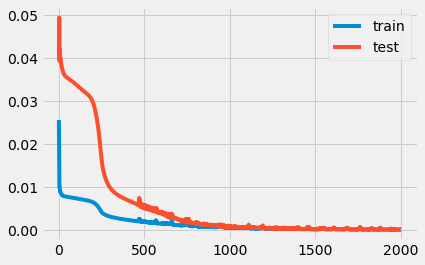

In [697]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[tf.keras.metrics.RootMeanSquaredError()])
# fit network
#  
history = model.fit(train_X, train_y, epochs=1000, batch_size=100, validation_data=(X_dev, y_dev), verbose=2, shuffle=False, callbacks=[model_checkpoint_callback])
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='dev')
plt.legend()
plt.show()

In [698]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_months*n_features))

In [699]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -5:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [700]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 86628.797


In [701]:
def month_to_year(month_preds):
    month_preds = month_preds[6:]
    year_preds = []
    for i in range(12, len(month_preds) + 1, 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [708]:
preds = month_to_year(inv_yhat).astype(np.int64)
actual = month_to_year(inv_y).astype(np.int64)
print(preds)
print(actual)

    Count
0  752122
1  455581
2  499542
3  307461
    Count
0  488981
1  336030
2  381773
3  535746


In [703]:
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)

    Count
0  498710
1  439060
2  294840
3  347600


In [704]:
return_rmse(actual, traditional)

The root mean squared error is 115829.72216361394.


In [705]:
return_rmse(actual, preds)

The root mean squared error is 193338.7019953565.


In [85]:
# def create_train_test(king_all):
#     king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
#     king_training = king_all[king_training_parse]
#     king_training = king_training.reset_index()
#     king_training = king_training.drop('index', axis=1)
    
#     king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
#     king_test = king_all[king_test_parse]
#     king_test = king_test.reset_index()
#     king_test = king_test.drop('index', axis=1)
#     print(king_test.shape)
    
#     # Normalizing Data
#     king_training[king_training["king"] < 0] = 0 
# #     print('max val king_train:')
#     print(max(king_training['king']))
#     king_test[king_test["king"] < 0] = 0
# #     print('max val king_test:')
#     print(max(king_test['king']))
#     king_train_pre = king_training["king"].to_frame()
# #     print(king_train_norm)
#     king_test_pre = king_test["king"].to_frame()
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     king_train_norm = scaler.fit_transform(king_train_pre)
#     king_test_norm = scaler.fit_transform(king_test_pre)
#     print('king_test_norm')
#     print(king_test_norm.shape)
#     print('king_train_norm')
#     print(king_train_norm.shape)
#     #king_train_norm = (king_training["king"] - np.min(king_training["king"])) / (np.max(king_training["king"]) - np.min(king_training["king"]))
#     #print(type(king_train_norm))
#     #king_train_norm = king_train_norm.to_frame()
#     x_train = []
#     y_train = []
#     x_test = []
#     y_test = []
#     y_test_not_norm = []
#     y_train_not_norm = []
    
#     # Todo: Experiment with input size of input (ex. 30 days)
    
#     for i in range(6,924): # 30
#         x_train.append(king_train_norm[i-6:i])
#         y_train.append(king_train_norm[i])
#     for i in range(6, 60):
#         x_test.append(king_test_norm[i-6:i])
#         y_test.append(king_test_norm[i])
    
#     # make y_test_not_norm
#     for i in range(6, 60):
#         y_test_not_norm.append(king_test['king'][i])
#     for i in range(6,924): # 30
#         y_train_not_norm.append(king_training['king'][i])
        
#     return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [86]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)


(60, 2)
717915
294611
king_test_norm
(60, 1)
king_train_norm
(924, 1)
(54, 1)
(54, 1)
(918, 1)
(918, 1)


In [176]:
# def load_pdo(pathname):
#     pdo_data = pd.read_csv(pathname)
# #     print(pdo_data.head())
#     return pdo_data

In [177]:
# ismael_path_pdo = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/pdo.csv'
# pdo_data = load_pdo(ismael_path_pdo)

In [178]:
# pdo = pdo_data["PDO"]
# data_copy = data_copy.join(pdo)

In [179]:
# pdo_data

In [180]:
# print(data_copy)